<a href="https://colab.research.google.com/github/hyewonleess/github_blog_posts/blob/main/blog_stocks__1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주식 데이터 분석
**데이터 구성**

출처: <https://programmers.co.kr/competitions/252/2020-miraeasset>
1.   trade_train.csv: 거래내역 데이터
2.   stocks.csv: 종목 데이터



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import lightgbm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import OrderedDict
import datetime

import warnings 
warnings.filterwarnings('ignore')

In [ ]:
# 한글 폰트 설정
!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='NanumBarunGothic')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load data
trade = pd.read_csv('/content/drive/My Drive/data/githublog/stock/trade_train.csv',header=0)
stocks = pd.read_csv('/content/drive/My Drive/data/githublog/stock/stocks.csv',header=0)

In [ ]:
trade = trade.iloc[:,1:]
trade.head()

,기준년월,그룹번호,그룹내고객수,종목번호,그룹내_매수여부,그룹내_매도여부,매수고객수,매도고객수,평균매수수량,평균매도수량,매수가격_중앙값,매도가격_중앙값
0,201907,MAD01,288,A000660,Y,Y,7,17,19,234,74800,78500
1,201907,MAD01,288,A001820,Y,Y,3,4,533,154,47385,46700
2,201907,MAD01,288,A004020,Y,Y,3,3,409,528,41411,40000
3,201907,MAD01,288,A005380,Y,Y,4,3,323,451,140602,140628
4,201907,MAD01,288,A005930,Y,Y,13,19,34,101,45350,46850


## Stocks data

In [ ]:
stocks = stocks.iloc[:,1:]
stocks.head()

,기준일자,종목번호,종목명,20년7월TOP3대상여부,시장구분,표준산업구분코드_대분류,표준산업구분코드_중분류,표준산업구분코드_소분류,종목시가,종목고가,종목저가,종목종가,거래량,거래금액_만원단위
0,20190701,A000020,동화약품,N,코스피,제조업,의료용 물질 및 의약품 제조업,의약품 제조업,9680,9840,9680,9710,31341,30581
1,20190701,A000080,하이트진로,N,코스피,제조업,음료 제조업,알코올음료 제조업,20550,20550,20200,20300,127186,258535
2,20190701,A000100,유한양행,Y,코스피,제조업,의료용 물질 및 의약품 제조업,의약품 제조업,259000,267500,250000,251500,395757,10139357
3,20190701,A000120,CJ대한통운,N,코스피,운수 및 창고업,육상운송 및 파이프라인 운송업,도로 화물 운송업,136500,137000,133000,136000,62513,846100
4,20190701,A000140,하이트진로홀딩스,Y,코스피,금융 및 보험업,금융업,기타 금융업,9060,9190,8910,9000,7661,6896


In [ ]:
# 이상한 데이터 있는지 점검
stocks.describe()

,기준일자,종목시가,종목고가,종목저가,종목종가,거래량,거래금액_만원단위
count,2.860610e+05,2.860610e+05,2.860610e+05,2.860610e+05,2.860610e+05,2.860610e+05,2.860610e+05
mean,2.019608e+07,2.362111e+04,2.415892e+04,2.312322e+04,2.365760e+04,1.437010e+06,1.237354e+06
std,4.714494e+03,6.317638e+04,6.423086e+04,6.215330e+04,6.318358e+04,6.748686e+06,5.192501e+06
min,2.019070e+07,0.000000e+00,0.000000e+00,0.000000e+00,7.300000e+01,0.000000e+00,0.000000e+00
25%,2.019101e+07,2.855000e+03,2.945000e+03,2.780000e+03,2.885000e+03,1.029780e+05,7.223600e+04
50%,2.020012e+07,7.240000e+03,7.460000e+03,7.050000e+03,7.250000e+03,2.848550e+05,2.349530e+05
75%,2.020042e+07,1.980000e+04,2.035000e+04,1.925000e+04,1.980000e+04,8.410610e+05,7.792680e+05
max,2.020073e+07,1.489000e+06,1.490000e+06,1.441000e+06,1.475000e+06,8.519666e+08,2.902883e+08


In [ ]:
# shape 확인
stocks.shape

(286061, 14)

In [ ]:
# 기준일자 시작일, 종료일
print(min(stocks['기준일자']))
print(max(stocks['기준일자']))

20190701
20200728


In [ ]:
# 거래량이 0인 종목(주가도 0)
stocks.loc[stocks['거래량']==0,'종목명'].unique()

array(['경남제약', '한국비엔씨', '플레이위드', 'GV', '한국테크놀로지', '제이콘텐트리', '우정바이오',
       '엔에스엔', '한류AI센터', '비비안', '이디티', '하이트진로홀딩스우', '서울바이오시스', '럭슬', '샘코',
       '셀바스헬스케어', '리메드', 'OQP', '시노펙스', '뉴인텍', '체시스', '지란지교시큐리티', '두산',
       '금호전기', '레이크머티리얼즈', '코스모화학', '네스엠', '에이치엘비생명과학', '에이치엘비', '카이노스메드',
       '에이치엘비파워', '두산퓨얼셀2우B', '두산솔루스2우B', '비덴트', '뉴로스', '셀루메드', '코센',
       '뉴파워프라즈마', '이원컴포텍', '퓨전', '엔케이물산', '에이아이비트', '세미콘라이트', '제낙스',
       '루미마이크로', '오리엔트바이오', '덕성우', '비케이탑스', '코디엠', '내츄럴엔도텍', '포티스', '수젠텍',
       '랩지노믹스', '메디앙스', '에이프런티어', '이큐셀', '팍스넷', '이에스에이', '멕아이씨에스',
       '진매트릭스', '흥아해운', '디에스티', '휴마시스', '아이에이네트웍스', '유한양행', '현진소재',
       '신풍제약', '자안', '주연테크', '에스모머티리얼즈', '코오롱생명과학', '경남제약헬스케어', '에코마이스터',
       '키이스트', '웅진씽크빅', '대덕', '이지홀딩스', '이노와이즈', '신라젠', '와이오엠', '블러썸엠앤씨',
       '삼성중공우', '미래산업', '두산퓨얼셀', '이지바이오', '대림제지', '크루셜텍', '한화우',
       '데일리블록체인', '솔브레인홀딩스', '메이슨캐피탈', '디오스텍', '신풍제약우', '신일제약', 'SK케미칼우'],
      dtype=object)

In [ ]:
# 거래량이 0인 데이터 제거
stocks = stocks[stocks['거래량']!=0]
stocks.shape

(283565, 14)

In [ ]:
# 종목 종류 수
len(stocks['종목번호'].unique())

1087

In [ ]:
# 필요없는 column drop
stocks.drop(['표준산업구분코드_중분류','표준산업구분코드_소분류'],axis=1,inplace=True)

In [ ]:
# 연도 추출
def get_ym(df):
  df = str(df)
  return df[:6]

In [ ]:
stocks['기준년월'] = stocks['기준일자'].apply(lambda x: get_ym(x))
stocks.head()

,기준일자,종목번호,종목명,20년7월TOP3대상여부,시장구분,표준산업구분코드_대분류,종목시가,종목고가,종목저가,종목종가,거래량,거래금액_만원단위,기준년월
0,20190701,A000020,동화약품,N,코스피,제조업,9680,9840,9680,9710,31341,30581,201907
1,20190701,A000080,하이트진로,N,코스피,제조업,20550,20550,20200,20300,127186,258535,201907
2,20190701,A000100,유한양행,Y,코스피,제조업,259000,267500,250000,251500,395757,10139357,201907
3,20190701,A000120,CJ대한통운,N,코스피,운수 및 창고업,136500,137000,133000,136000,62513,846100,201907
4,20190701,A000140,하이트진로홀딩스,Y,코스피,금융 및 보험업,9060,9190,8910,9000,7661,6896,201907


In [ ]:
# 기준년월별 평균 그룹화
df = stocks.groupby(['기준년월','종목명','20년7월TOP3대상여부','시장구분','표준산업구분코드_대분류'])['종목시가','종목고가','종목저가','종목종가','거래량','거래금액_만원단위'].mean().reset_index()
df.head()

,기준년월,종목명,20년7월TOP3대상여부,시장구분,표준산업구분코드_대분류,종목시가,종목고가,종목저가,종목종가,거래량,거래금액_만원단위
0,201907,3S,N,코스닥,제조업,3095.869565,3240.652174,2940.652174,3093.478261,2.089129e+06,711216.434783
1,201907,APS홀딩스,N,코스닥,금융 및 보험업,6987.391304,7300.000000,6780.434783,7033.913043,5.740889e+05,403974.086957
2,201907,AP시스템,N,코스닥,제조업,24843.478261,25423.913043,24230.434783,24741.304348,1.922852e+05,475265.043478
3,201907,CJ,N,코스피,금융 및 보험업,97613.043478,98517.391304,96608.695652,97282.608696,4.881057e+04,475704.739130
4,201907,CJCGV,N,코스피,정보통신업,37126.086957,37658.695652,36493.478261,37000.000000,1.420171e+05,531612.652174


### 1. 주요 대기업 주가 변동 살펴보기
대상: 삼성전자, 현대차, NAVER, SK하이닉스

In [ ]:
stocks['기준일자'] = pd.to_datetime(stocks['기준일자'],format='%Y%m%d')

In [ ]:
stocks[['거래량','종목종가']].corr()

,거래량,종목종가
거래량,1.000000,-0.051454
종목종가,-0.051454,1.000000


In [ ]:
stocks['가격변동'] = stocks['종목종가'] - stocks['종목시가']

#### (1) 삼성전자 주가변동

In [ ]:
samsung = stocks[stocks['종목명']=='삼성전자']
# 이동평균 계산
samsung['MA5'] = round(samsung['종목종가'].rolling(window=5, min_periods=1).mean(),0)
samsung['MA20'] = round(samsung['종목종가'].rolling(window=20, min_periods=1).mean(),0)
samsung['MA60'] = round(samsung['종목종가'].rolling(window=60, min_periods=1).mean(),0)
samsung['MA120'] = round(samsung['종목종가'].rolling(window=120, min_periods=1).mean(),0)
samsung.head()

,기준일자,종목번호,종목명,20년7월TOP3대상여부,시장구분,표준산업구분코드_대분류,종목시가,종목고가,종목저가,종목종가,거래량,거래금액_만원단위,기준년월,가격변동,MA5,MA20,MA60,MA120
114,2019-07-01,A005930,삼성전자,Y,코스피,제조업,47350,47400,46250,46600,11383522,53156861,201907,-750,46600.0,46600.0,46600.0,46600.0
1141,2019-07-02,A005930,삼성전자,Y,코스피,제조업,46200,46900,45850,46250,8463073,39304819,201907,50,46425.0,46425.0,46425.0,46425.0
2168,2019-07-03,A005930,삼성전자,Y,코스피,제조업,45750,46350,45200,45400,9669368,44106491,201907,-350,46083.0,46083.0,46083.0,46083.0
3195,2019-07-04,A005930,삼성전자,Y,코스피,제조업,45250,46200,45250,46000,6365573,29145361,201907,750,46062.0,46062.0,46062.0,46062.0
4222,2019-07-05,A005930,삼성전자,Y,코스피,제조업,45950,45950,45250,45650,7235395,32944675,201907,-300,45980.0,45980.0,45980.0,45980.0


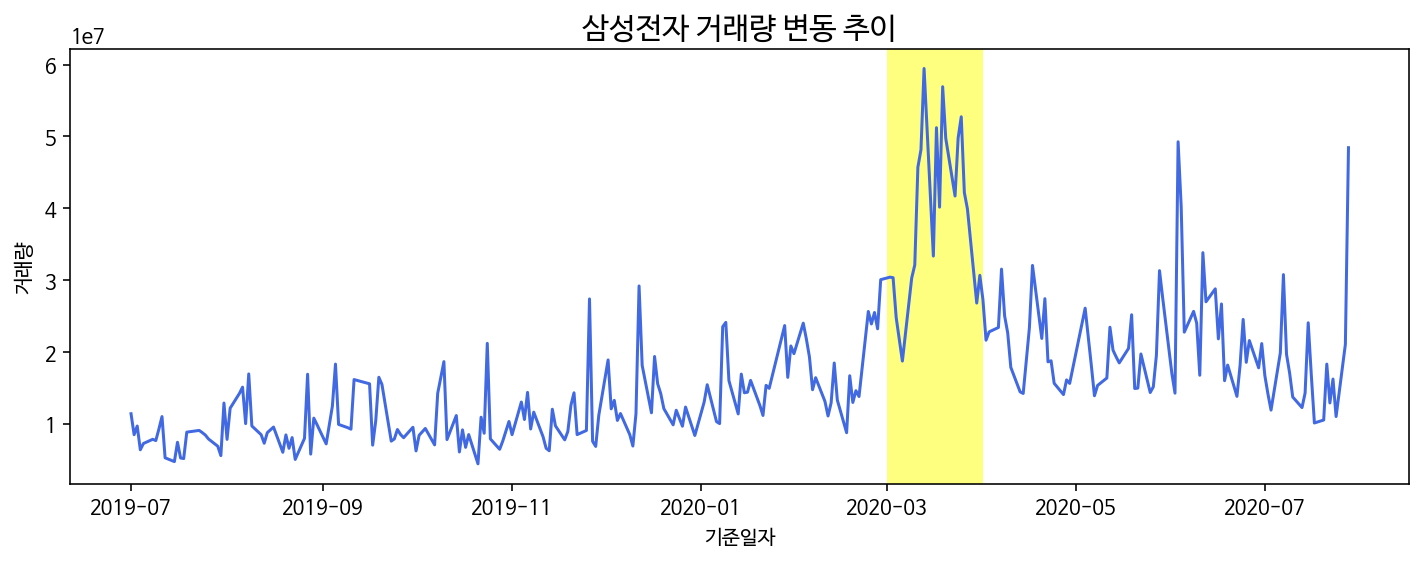

In [ ]:
plt.figure(figsize=(12,4))
sns.lineplot(data=samsung,x='기준일자',y='거래량',color='royalblue')
plt.axvspan(datetime.datetime(2020,3,1),datetime.datetime(2020,4,1),facecolor='yellow',alpha=0.5)
plt.title('삼성전자 거래량 변동 추이',fontsize=15)
plt.show()

In [ ]:
# color
cmap = list(map(lambda x: 'blue' if x>0 else 'red',samsung['가격변동']))

In [ ]:
def plot_trend(df,name):
  from matplotlib import gridspec

  plt.figure(figsize=(20, 8))                  
  gs = gridspec.GridSpec(nrows=2, ncols=1,    
                       height_ratios=[5, 1]) 

##############################################
  plt.subplot(gs[0])                         
  # 캔들스틱 그리는 코드 넣을 자리 
  plt.subplot(gs[0])
  plt.title(f'{name} 주식캔들',fontsize=15)
  plt.bar(df['기준일자'],height=df['종목종가']-df['종목시가'],bottom=df['종목시가'],color=cmap)
  plt.vlines(df['기준일자'],df['종목저가'],df['종목고가'],colors=cmap)
  plt.axvspan(datetime.datetime(2020,3,1),datetime.datetime(2020,4,1),facecolor='yellow',alpha=0.5)
  sns.lineplot(df['기준일자'],df['MA5'],color='orange',label='MA5',alpha=0.5);sns.lineplot(df['기준일자'],df['MA20'],color='green',label='MA20',alpha=0.5);
  sns.lineplot(df['기준일자'],df['MA60'],color='purple',label='MA60',alpha=0.5);sns.lineplot(df['기준일자'],df['MA120'],color='pink',label='MA120',alpha=0.5);
  plt.ylabel('주가');

  plt.subplot(gs[1])                       
  sns.lineplot(data=df,x='기준일자',y='거래량',color='green')
  plt.axvspan(datetime.datetime(2020,3,1),datetime.datetime(2020,4,1),facecolor='yellow',alpha=0.5)
  plt.title(f'{name} 거래량 변동 추이',fontsize=15)

##############################################

  plt.subplots_adjust(wspace = 0, hspace = 0)  
  plt.show()

def plot_trend_ver2(df,name):
  from matplotlib import gridspec

  plt.figure(figsize=(20, 8))                 
  gs = gridspec.GridSpec(nrows=2, ncols=1,    
                       height_ratios=[5, 1]) 

##############################################
  plt.subplot(gs[0])                         
  # 캔들스틱 그리는 코드 넣을 자리 
  plt.subplot(gs[0])
  plt.title(f'{name} 주식캔들',fontsize=15)
  plt.bar(df['기준일자'],height=df['종목종가']-df['종목시가'],bottom=df['종목시가'],color=cmap)
  plt.vlines(df['기준일자'],df['종목저가'],df['종목고가'],colors=cmap)
  sns.lineplot(df['기준일자'],df['MA5'],color='orange',label='MA5',alpha=0.5);sns.lineplot(df['기준일자'],df['MA20'],color='green',label='MA20',alpha=0.5);
  sns.lineplot(df['기준일자'],df['MA60'],color='purple',label='MA60',alpha=0.5);sns.lineplot(df['기준일자'],df['MA120'],color='pink',label='MA120',alpha=0.5);
  plt.ylabel('주가');

  plt.subplot(gs[1])                       
  sns.lineplot(data=df,x='기준일자',y='거래량',color='green')
  plt.title(f'{name} 거래량 변동 추이',fontsize=15)

##############################################

  plt.subplots_adjust(wspace = 0, hspace = 0)  # 구획(subplot) 간의 간격을 없앤다.
  plt.show()


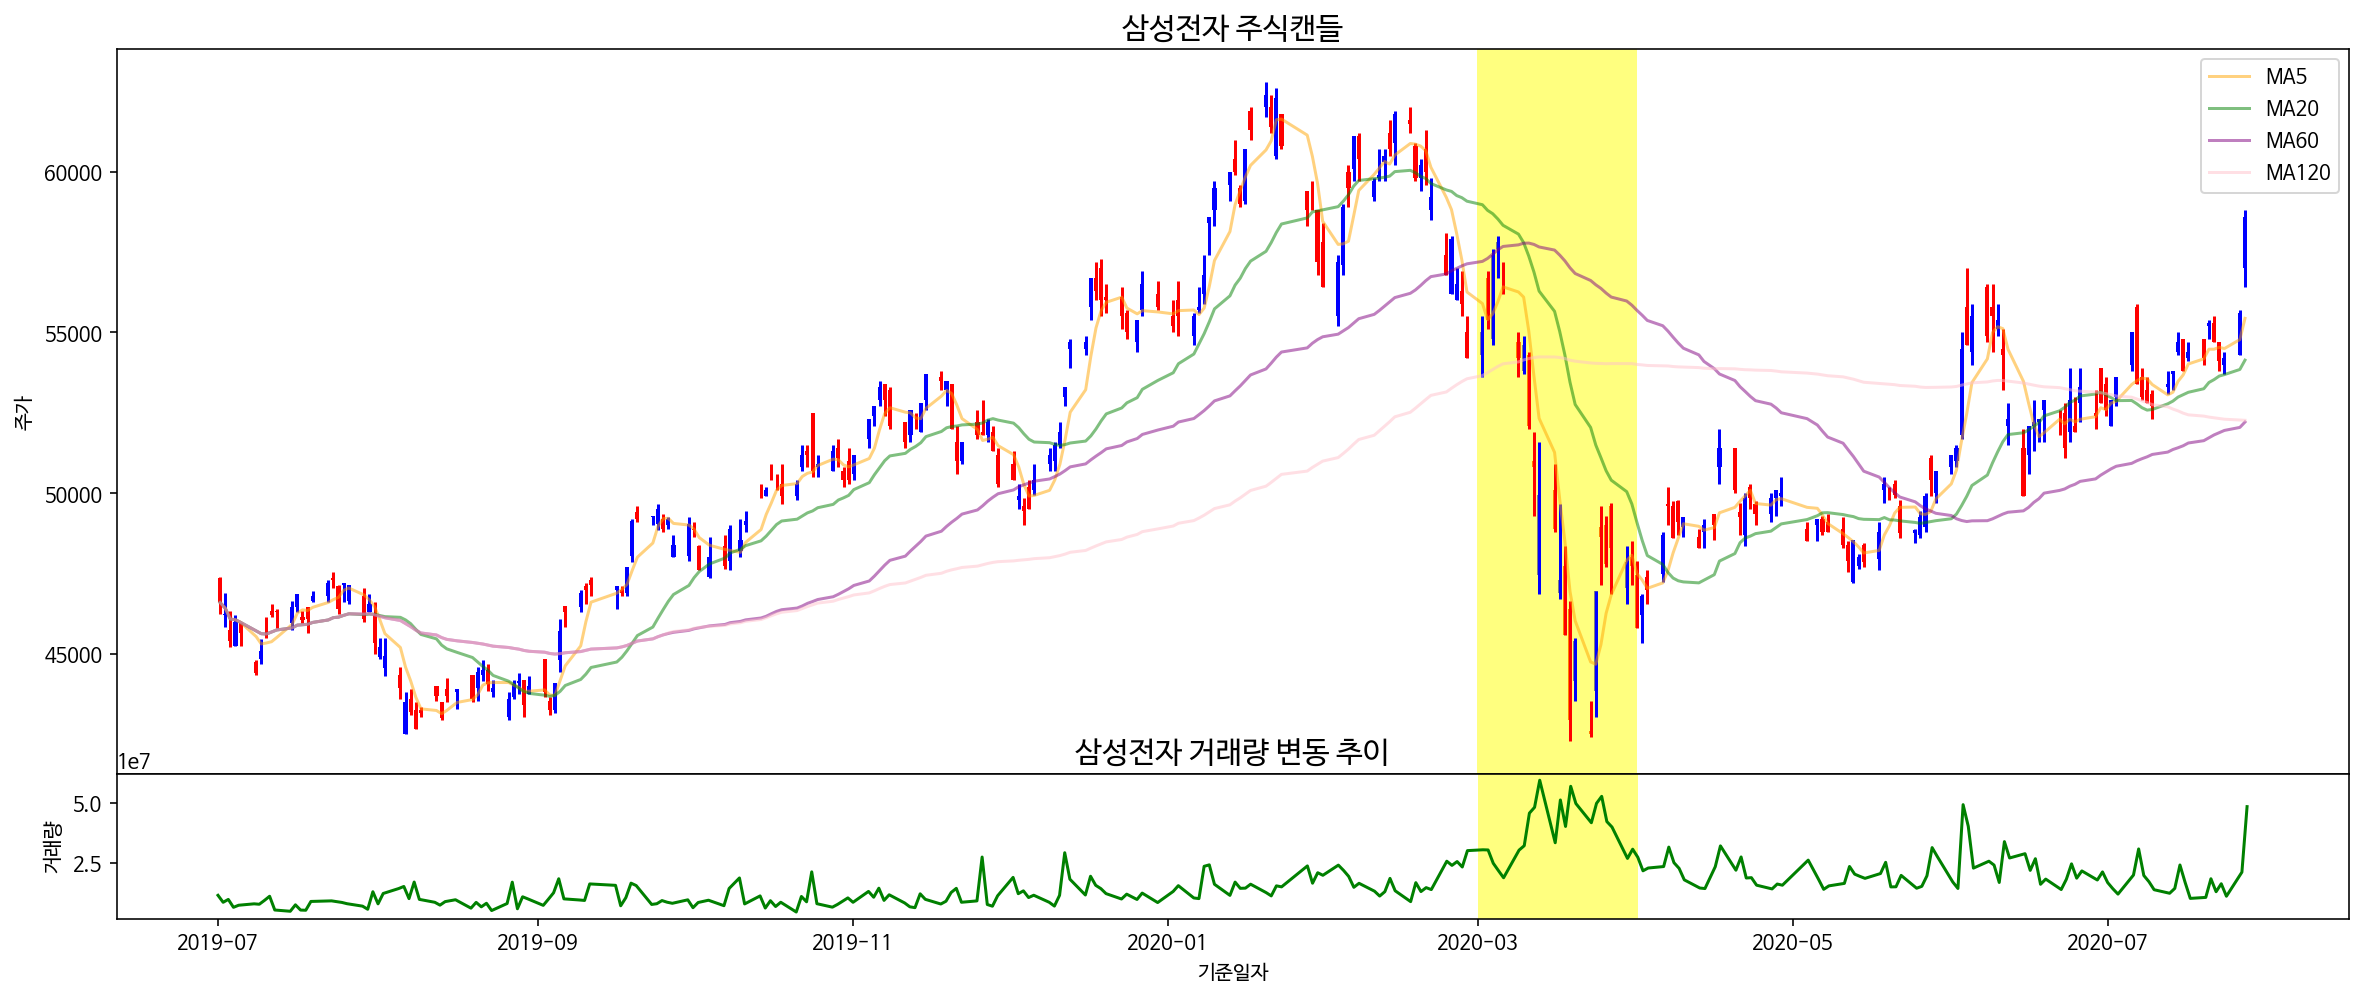

In [ ]:
plot_trend(samsung,'삼성전자')

#### (2) 현대차 주가변동

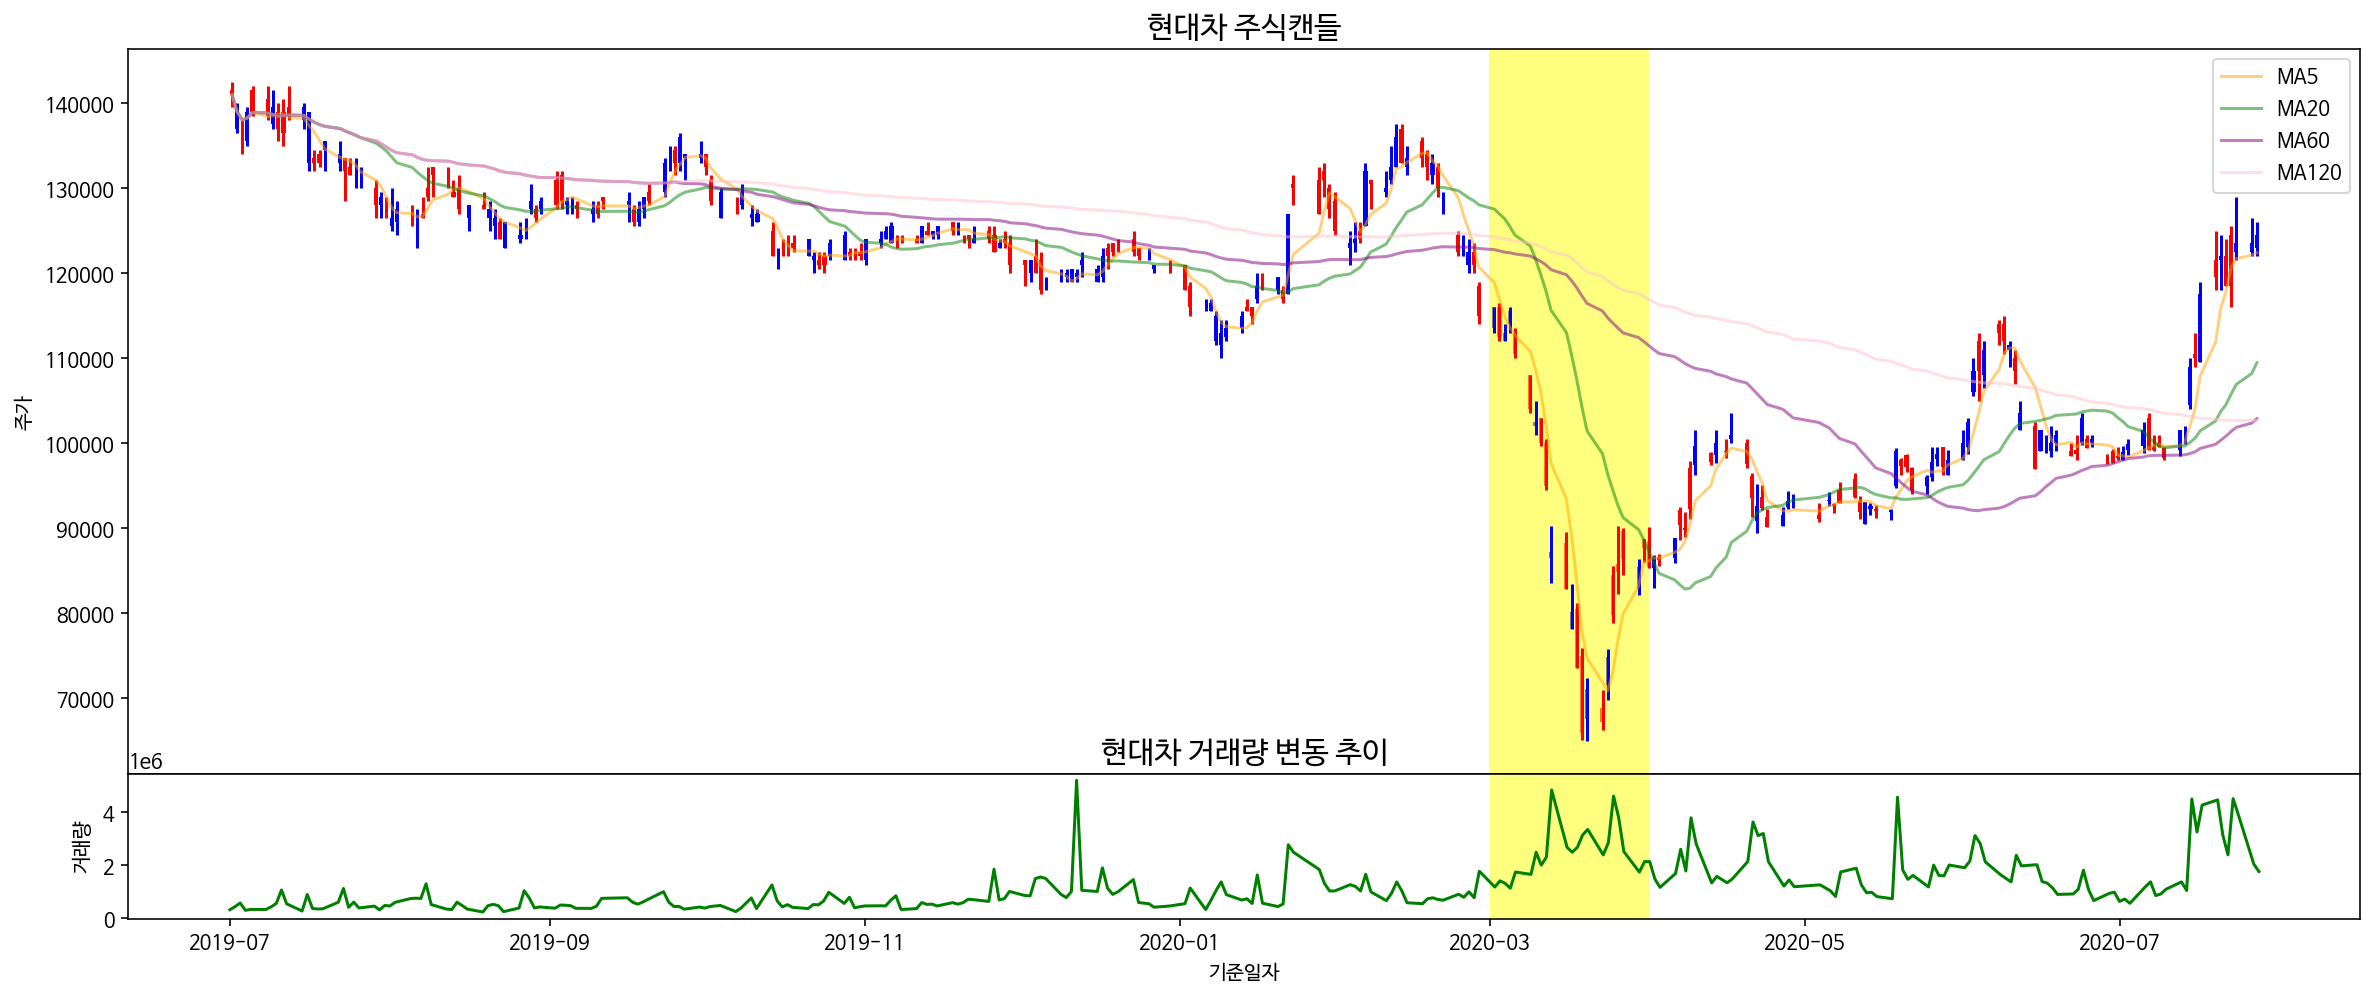

In [ ]:
hyundai = stocks[stocks['종목명']=='현대차']
hyundai['MA5'] = round(hyundai['종목종가'].rolling(window=5, min_periods=1).mean(),0)
hyundai['MA20'] = round(hyundai['종목종가'].rolling(window=20, min_periods=1).mean(),0)
hyundai['MA60'] = round(hyundai['종목종가'].rolling(window=60, min_periods=1).mean(),0)
hyundai['MA120'] = round(hyundai['종목종가'].rolling(window=120, min_periods=1).mean(),0)
plot_trend(hyundai,'현대차')

#### (3) 네이버 주가변동

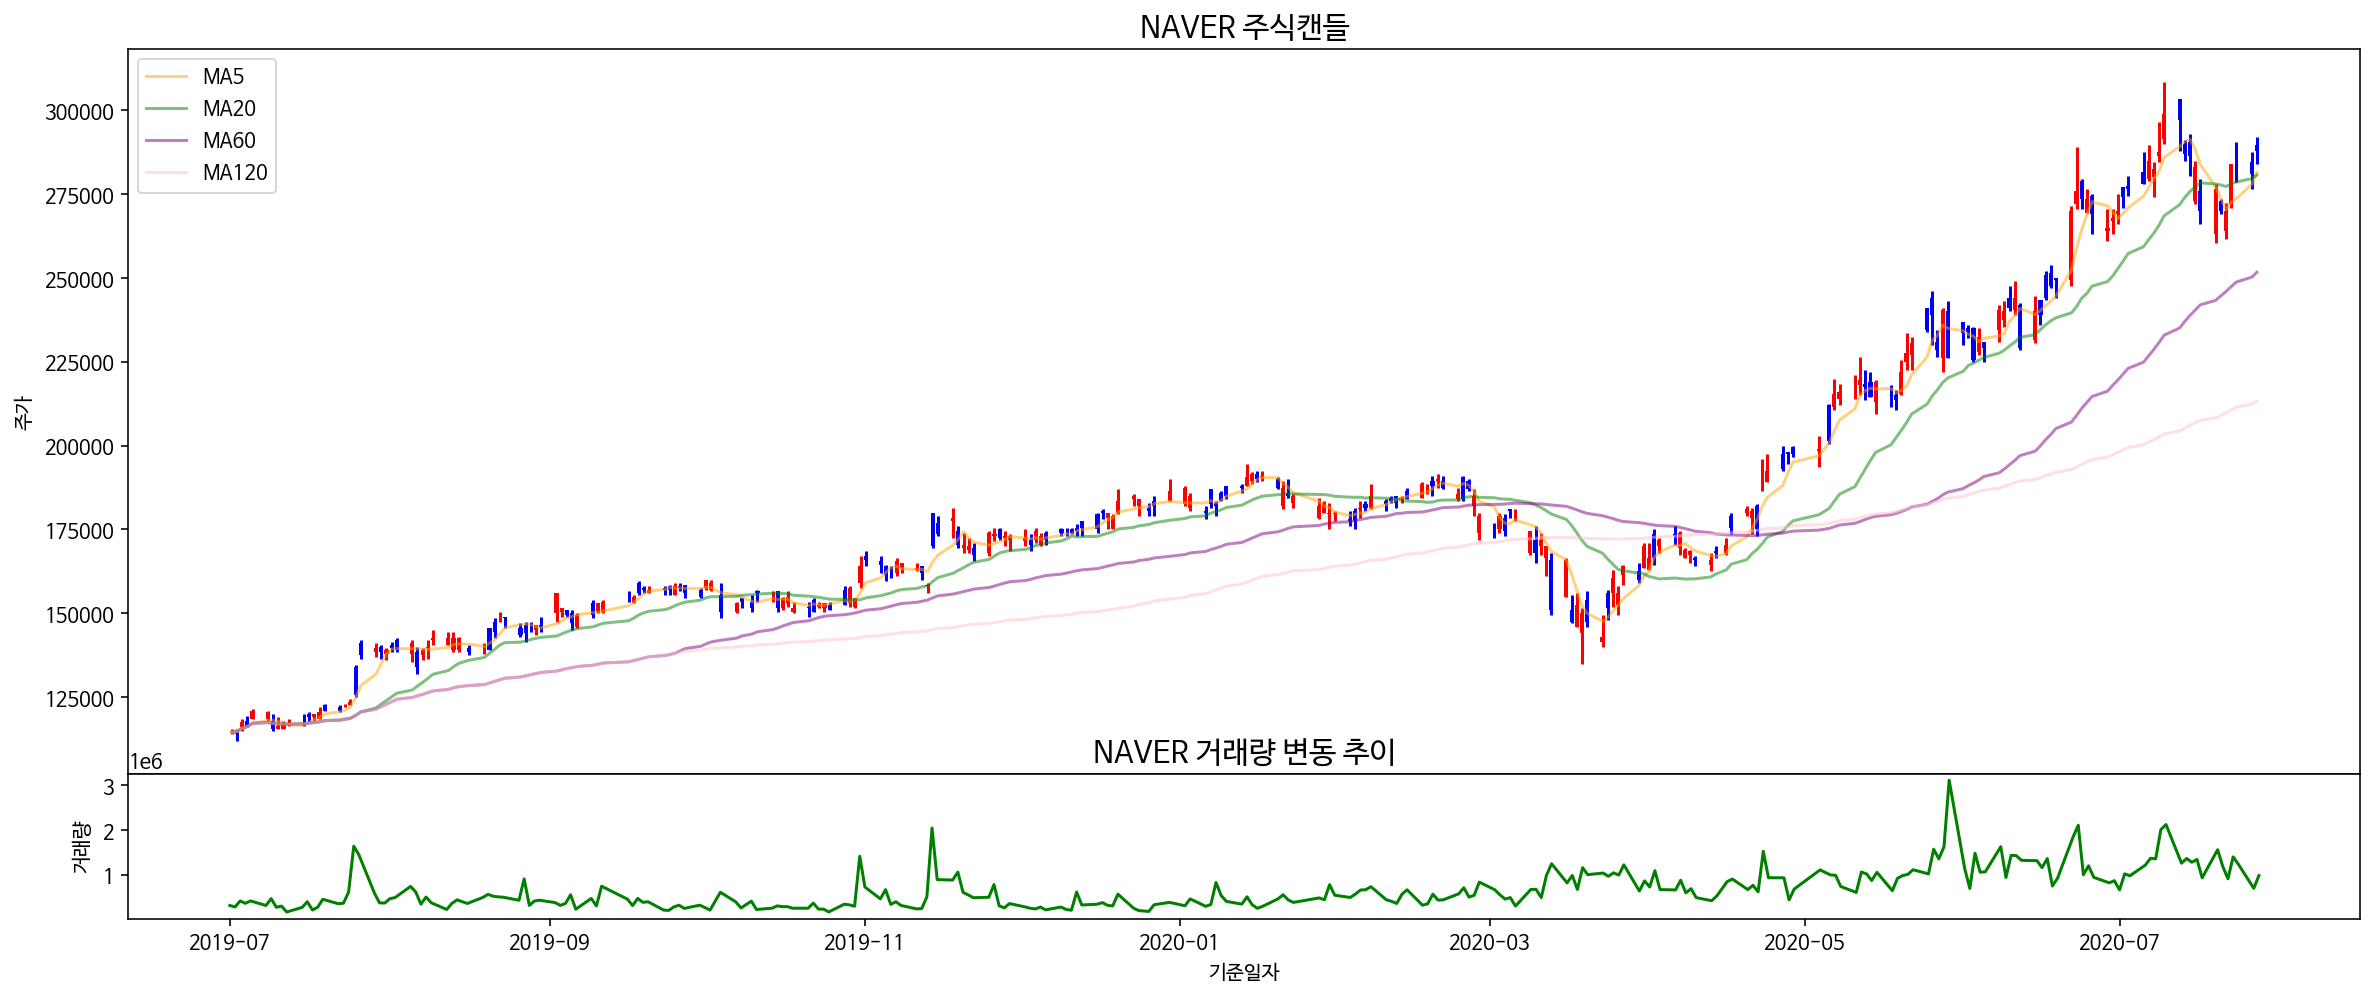

In [ ]:
naver = stocks[stocks['종목명']=='NAVER']
naver['MA5'] = round(naver['종목종가'].rolling(window=5, min_periods=1).mean(),0)
naver['MA20'] = round(naver['종목종가'].rolling(window=20, min_periods=1).mean(),0)
naver['MA60'] = round(naver['종목종가'].rolling(window=60, min_periods=1).mean(),0)
naver['MA120'] = round(naver['종목종가'].rolling(window=120, min_periods=1).mean(),0)
plot_trend_ver2(naver,'NAVER')